In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV

from sklearn.metrics import roc_auc_score, roc_curve, auc

####################################################
# Load the data
df = pd.read_csv("n/full_data_flightdelay.csv.xz", compression='xz')
# df = pd.read_csv("test.csv.xz", compression='xz')
#print(df.head())

# take a random sample of 1000 rows
df = df.sample(n=10000, random_state=42)

ontime = df[df['DEP_DEL15'] == 0]
delayed = df[df['DEP_DEL15'] == 1]

In [2]:
# DATA CLEANING
# encode the categorical data
le = LabelEncoder()

def clean_labels_encoder(list_of_labels, df):
    for label in list_of_labels:
        df[label] = le.fit_transform(df[label])
    return df

# clean the labels
list_of_labels = ['CARRIER_NAME', 'DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT', 'DEP_TIME_BLK']
df = clean_labels_encoder(list_of_labels, df)

# Drop the columns that are not needed
# df = df.drop(['CARRIER_HISTORICAL', 'DEP_AIRPORT_HIST', 'DAY_HISTORICAL',
#        'DEP_BLOCK_HIST'], axis=1)

# Fill the missing values
df.fillna(df.mean(), inplace=True)

Standard Scaler
Random Forest
0.793
Cross Validation value is  0.792
[[1579   16]
 [ 398    7]]
              precision    recall  f1-score   support

           0       0.80      0.99      0.88      1595
           1       0.30      0.02      0.03       405

    accuracy                           0.79      2000
   macro avg       0.55      0.50      0.46      2000
weighted avg       0.70      0.79      0.71      2000

0.5036263013274508


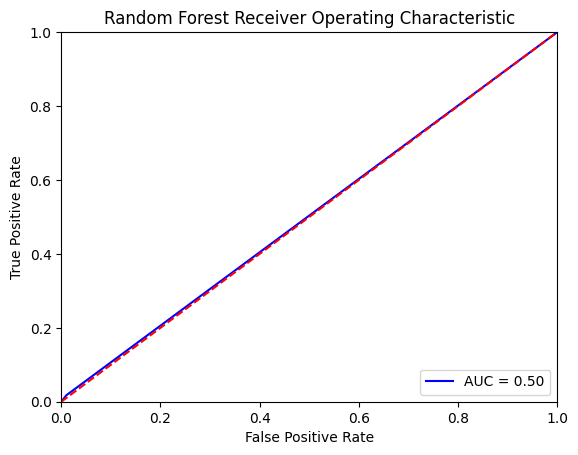

KNN
0.7815
Cross Validation value is  0.767
[[1511   84]
 [ 353   52]]
              precision    recall  f1-score   support

           0       0.81      0.95      0.87      1595
           1       0.38      0.13      0.19       405

    accuracy                           0.78      2000
   macro avg       0.60      0.54      0.53      2000
weighted avg       0.72      0.78      0.74      2000

0.5378652424629436


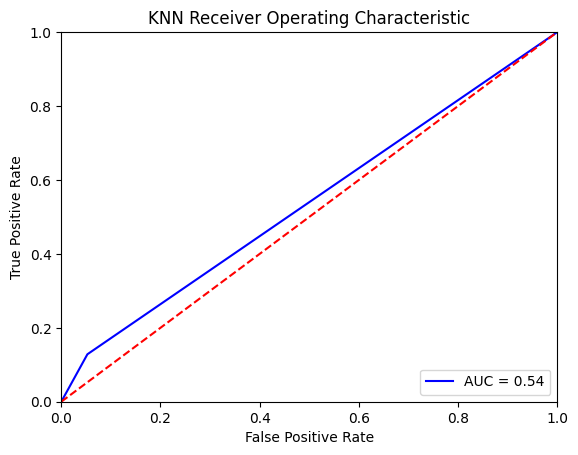

SVM
0.6325
Cross Validation value is  0.6094999999999999
[[1036  559]
 [ 176  229]]
              precision    recall  f1-score   support

           0       0.85      0.65      0.74      1595
           1       0.29      0.57      0.38       405

    accuracy                           0.63      2000
   macro avg       0.57      0.61      0.56      2000
weighted avg       0.74      0.63      0.67      2000

0.6074809396648476


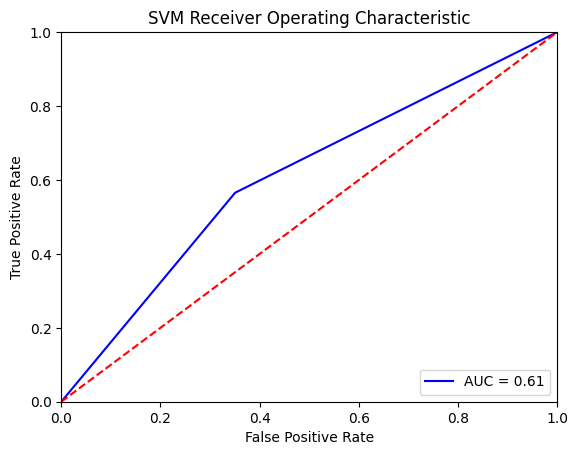

LGBM
0.6705
Cross Validation value is  0.7025
[[1112  483]
 [ 176  229]]
              precision    recall  f1-score   support

           0       0.86      0.70      0.77      1595
           1       0.32      0.57      0.41       405

    accuracy                           0.67      2000
   macro avg       0.59      0.63      0.59      2000
weighted avg       0.75      0.67      0.70      2000

0.6313053910755061


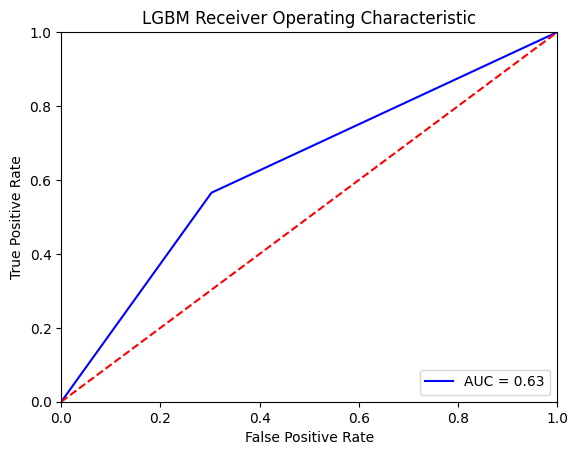

MinMax Scaler
Random Forest
0.796
Cross Validation value is  0.7929999999999999
[[1583   12]
 [ 396    9]]
              precision    recall  f1-score   support

           0       0.80      0.99      0.89      1595
           1       0.43      0.02      0.04       405

    accuracy                           0.80      2000
   macro avg       0.61      0.51      0.46      2000
weighted avg       0.72      0.80      0.72      2000

0.5073493556252177


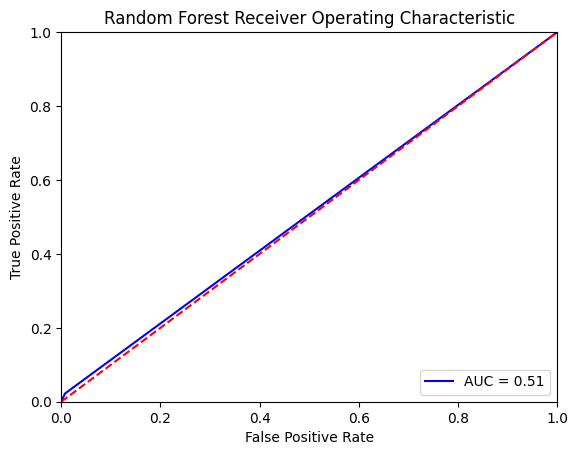

KNN
0.77
Cross Validation value is  0.767
[[1493  102]
 [ 358   47]]
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      1595
           1       0.32      0.12      0.17       405

    accuracy                           0.77      2000
   macro avg       0.56      0.53      0.52      2000
weighted avg       0.71      0.77      0.73      2000

0.5260497697279307


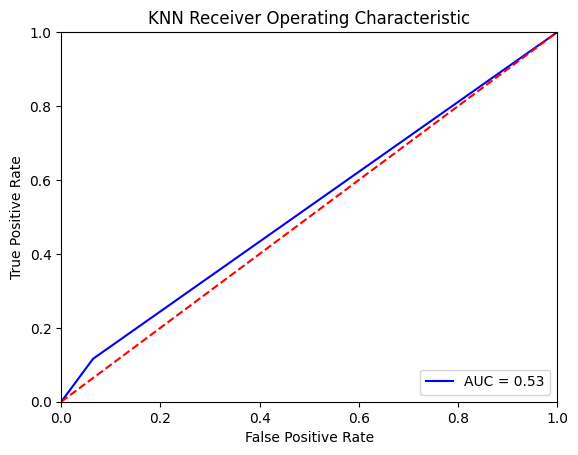

SVM
0.606
Cross Validation value is  0.5780000000000001
[[962 633]
 [155 250]]
              precision    recall  f1-score   support

           0       0.86      0.60      0.71      1595
           1       0.28      0.62      0.39       405

    accuracy                           0.61      2000
   macro avg       0.57      0.61      0.55      2000
weighted avg       0.74      0.61      0.64      2000

0.6102093734277643


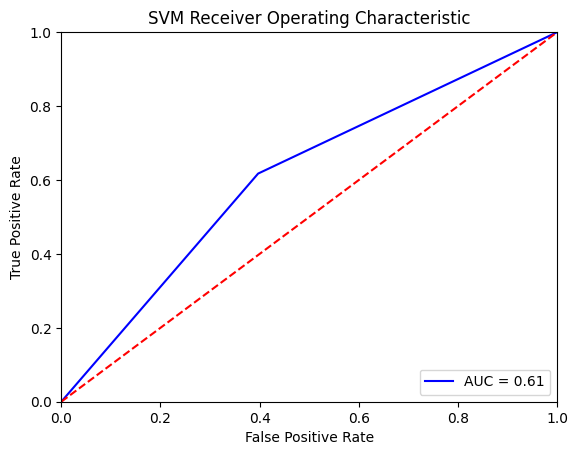

LGBM
0.6685
Cross Validation value is  0.6905
[[1108  487]
 [ 176  229]]
              precision    recall  f1-score   support

           0       0.86      0.69      0.77      1595
           1       0.32      0.57      0.41       405

    accuracy                           0.67      2000
   macro avg       0.59      0.63      0.59      2000
weighted avg       0.75      0.67      0.70      2000

0.6300514725802083


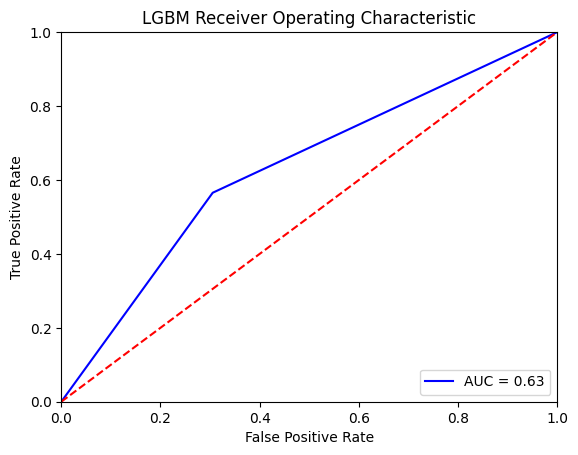

In [3]:
# Perform Random Forest, KNN, SVM, and LGBM with weighted data

def perform_classification_weighted(df):
    X = df.drop(['DEP_DEL15'], axis=1)
    y = df['DEP_DEL15']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    weights = (y_train == 0).sum() / (1.0 * (y_train == 1).sum())
    classifiers = {RandomForestClassifier(class_weight={0: 1, 1: weights}): 'Random Forest', 
               KNeighborsClassifier(n_neighbors=5): 'KNN', 
               SVC(class_weight={0: 1, 1: weights}): 'SVM',
               LGBMClassifier(boosting_type='dart', verbose=-1, 
                              class_weight={0: 1, 1: weights}, 
                              random_state=42): 'LGBM'}
    accuracy_scores = []
    cross_val_scores = []
    roc_auc_scores = []
    classification_reports = []
    confusion_matrices = []
    roc_thresholds = []
    


    scalers = {StandardScaler():"Standard Scaler", MinMaxScaler(): "MinMax Scaler"}
    for scaler, name_scaler in scalers.items():
        print(name_scaler)
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        for clf, name in classifiers.items():
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            print(name)
            print(accuracy_score(y_test, y_pred))
            print("Cross Validation value is ",np.mean(cross_val_score(clf ,X_test,y_test,cv=5)))
            print(confusion_matrix(y_test, y_pred))
            print(classification_report(y_test, y_pred))
            print(roc_auc_score(y_test, y_pred))
            fpr, tpr, threshold = roc_curve(y_test, y_pred)
            roc_auc = auc(fpr, tpr)
            accuracy_scores.append(accuracy_score(y_test, y_pred))
            cross_val_scores.append(np.mean(cross_val_score(clf ,X_test,y_test,cv=5)))
            roc_auc_scores.append(roc_auc_score(y_test, y_pred))
            classification_reports.append(classification_report(y_test, y_pred))
            confusion_matrices.append(confusion_matrix(y_test, y_pred))
            roc_thresholds.append(roc_curve(y_test, y_pred))

            #method I: plt
            plt.title(name + ' Receiver Operating Characteristic')
            plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_score(y_test, y_pred))
            plt.legend(loc = 'lower right')
            plt.plot([0, 1], [0, 1],'r--')
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')
            plt.show()
    return accuracy_scores, cross_val_scores, roc_auc_scores, classification_reports, confusion_matrices, roc_thresholds
    

accuracy_scores, cross_val_scores, roc_auc_scores, classification_reports, confusion_matrices, roc_thresholds = perform_classification_weighted(df)

# print(accuracy_scores)
# print(cross_val_scores)
# print(roc_auc_scores)
# print(classification_reports)
# print(confusion_matrices)




Fitting estimator with 25 features.
Fitting estimator with 24 features.
RFECV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
      scoring='neg_mean_squared_error', verbose=1)
Optimal number of features 23
[21 22]
Index(['SNOW', 'SNWD'], dtype='object')
Random Forest
0.796
Cross Validation value is  0.7929999999999999
[[1582   13]
 [ 395   10]]
              precision    recall  f1-score   support

           0       0.80      0.99      0.89      1595
           1       0.43      0.02      0.05       405

    accuracy                           0.80      2000
   macro avg       0.62      0.51      0.47      2000
weighted avg       0.73      0.80      0.72      2000

0.5082704439026279


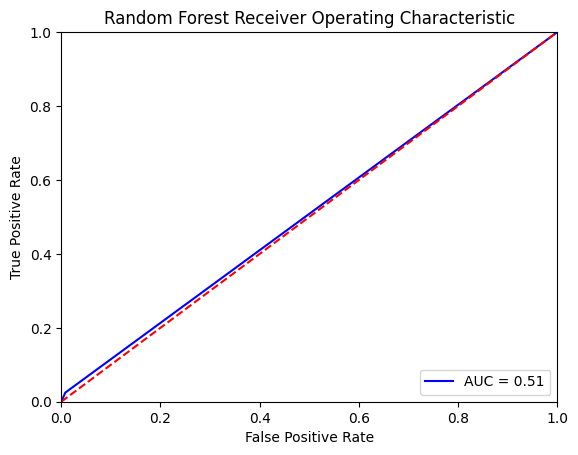

KNN
0.769
Cross Validation value is  0.7655
[[1492  103]
 [ 359   46]]
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      1595
           1       0.31      0.11      0.17       405

    accuracy                           0.77      2000
   macro avg       0.56      0.52      0.52      2000
weighted avg       0.71      0.77      0.72      2000

0.5245017222028716


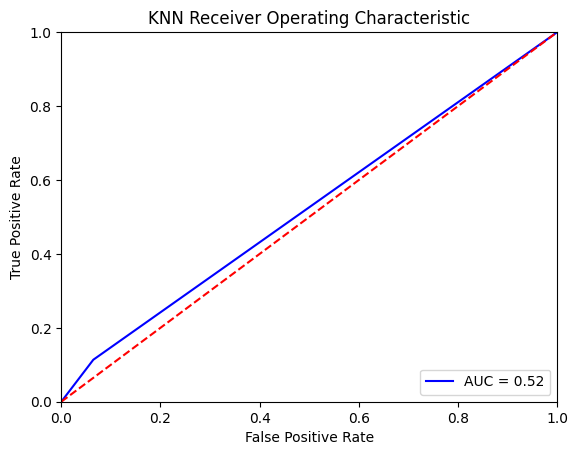

SVM
0.7975
Cross Validation value is  0.7975
[[1595    0]
 [ 405    0]]
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1595
           1       0.00      0.00      0.00       405

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.44      2000
weighted avg       0.64      0.80      0.71      2000

0.5


C:\Users\Fraser\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Fraser\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Fraser\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1344: U

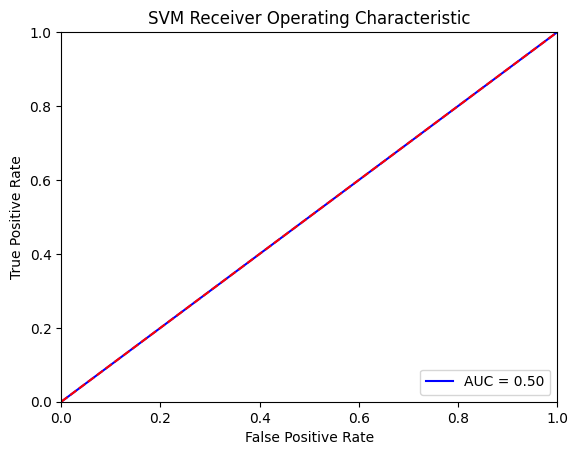

LGBM
0.6995
Cross Validation value is  0.7324999999999999
[[1213  382]
 [ 219  186]]
              precision    recall  f1-score   support

           0       0.85      0.76      0.80      1595
           1       0.33      0.46      0.38       405

    accuracy                           0.70      2000
   macro avg       0.59      0.61      0.59      2000
weighted avg       0.74      0.70      0.72      2000

0.6098804133286891


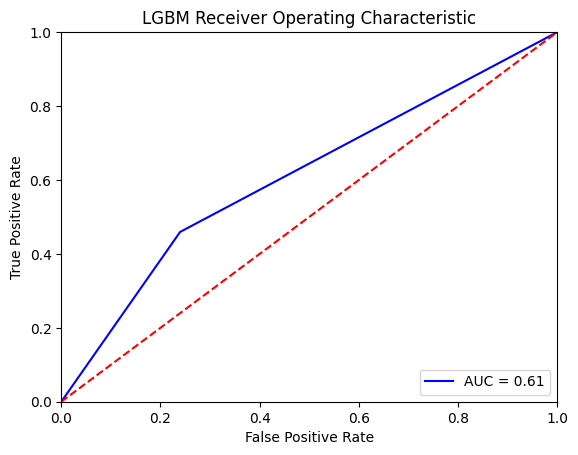

In [4]:
# Perform Recursive Feature Elimination

from sklearn.ensemble import RandomForestClassifier


def perform_rfe(df):
    X = df.drop(['DEP_DEL15'], axis=1)
    y = df['DEP_DEL15']


    clf = RandomForestClassifier()
    selector = RFECV(clf, step=1, scoring='neg_mean_squared_error',cv=5, verbose=1, n_jobs=-1)
    selector.fit(X, y)
    selector.transform(X)
    print(selector)
    print("Optimal number of features {}".format(selector.n_features_))
    print(np.where(selector.support_ == False)[0])
    print(X.columns[selector.support_ == False])
    X.drop(X.columns[selector.support_ == False], axis=1, inplace=True)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    weights = (y_train == 0).sum() / (1.0 * (y_train == 1).sum())
    classifiers = {RandomForestClassifier(): 'Random Forest', 
               KNeighborsClassifier(n_neighbors=5): 'KNN', 
               SVC(): 'SVM',
               LGBMClassifier(verbose=-1, class_weight={0: 1, 1: weights}): 'LGBM'}
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    for clf, name in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(accuracy_score(y_test, y_pred))
        print("Cross Validation value is ",np.mean(cross_val_score(clf ,X_test,y_test,cv=5)))
        print(confusion_matrix(y_test, y_pred))
        print(classification_report(y_test, y_pred))
        print(roc_auc_score(y_test, y_pred))
        fpr, tpr, threshold = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)

        # method I: plt
        plt.title(name + ' Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

perform_rfe(df)


Fitting 5 folds for each of 120 candidates, totalling 600 fits
{'lambda_l1': 1.5, 'lambda_l2': 1, 'min_data_in_leaf': 400, 'num_leaves': 31, 'reg_alpha': 0.1}
0.6069473909782492
0.6375
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Cross Validation value is  0.6567901234567901
[[1017  578]
 [ 147  258]]
              precision    recall  f1-score   support

           0       0.87      0.64      0.74      1595
           1       0.31      0.64      0.42       405

    accuracy                           0.64      2000
   macro avg       0.59      0.64      0.58      2000
weighted avg       0.76      0.64      0.67      2000

0.6373272959479857


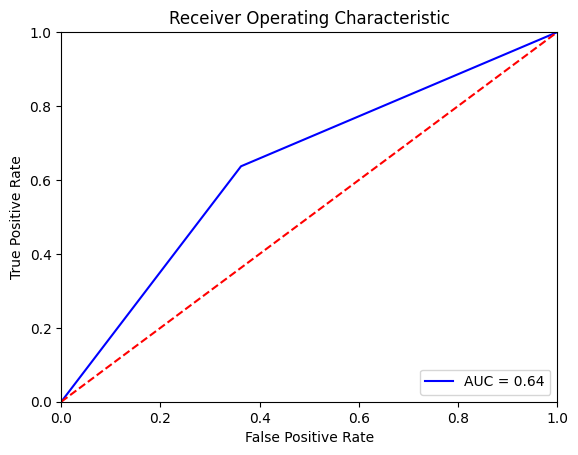

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 120 candidates, totalling 600 fits


[0.6375,
 0.6567901234567901,
 array([[1017,  578],
        [ 147,  258]], dtype=int64),
 '              precision    recall  f1-score   support\n\n           0       0.87      0.64      0.74      1595\n           1       0.31      0.64      0.42       405\n\n    accuracy                           0.64      2000\n   macro avg       0.59      0.64      0.58      2000\nweighted avg       0.76      0.64      0.67      2000\n',
 0.6373272959479857,
 array([0.        , 0.36238245, 1.        ]),
 array([0.        , 0.63703704, 1.        ]),
 0.6373272959479857]

In [5]:
# Perform Hyperparameter tuning on the LGBM model


def perform_hyperparameter_tuning(df):
    X = df.drop(['DEP_DEL15'], axis=1)
    y = df['DEP_DEL15']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    weights = (y_train == 0).sum() / (1.0 * (y_train == 1).sum())
    lgbm = LGBMClassifier(boosting_type='dart', verbose=-1, 
                          class_weight={0: 1, 1: weights}, 
                          random_state=42)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    param_grid = {
        'num_leaves': [31, 127],
        'reg_alpha': [0.1, 0.5],
        'min_data_in_leaf': [30, 50, 100, 300, 400],
        'lambda_l1': [0, 1, 1.5],
        'lambda_l2': [0, 1],
        
    }
    grid_search = GridSearchCV(lgbm, param_grid, cv=5, verbose=1, n_jobs=-1, scoring='recall')
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)
    print(grid_search.best_score_)
    y_pred = grid_search.predict(X_test)
    print(accuracy_score(y_test, y_pred))
    print("Cross Validation value is ",np.mean(cross_val_score(grid_search ,X_test,y_test,cv=5)))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print(roc_auc_score(y_test, y_pred))
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # method I: plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    return [accuracy_score(y_test, y_pred), np.mean(cross_val_score(grid_search ,X_test,y_test,cv=5)), 
            confusion_matrix(y_test, y_pred), classification_report(y_test, y_pred), 
            roc_auc_score(y_test, y_pred), fpr, tpr, roc_auc]

perform_hyperparameter_tuning(df)



C:\Users\Fraser\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Standard Scaler
Random Forest
0.8293103448275863
Cross Validation value is  0.8310344827586207
[[1440    9]
 [ 288    3]]
              precision    recall  f1-score   support

         0.0       0.83      0.99      0.91      1449
         1.0       0.25      0.01      0.02       291

    accuracy                           0.83      1740
   macro avg       0.54      0.50      0.46      1740
weighted avg       0.74      0.83      0.76      1740

0.502049049113146


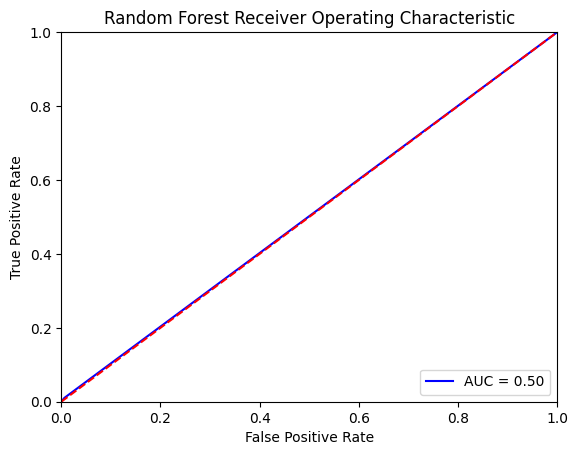

KNN
0.8086206896551724
Cross Validation value is  0.8126436781609195
[[1383   66]
 [ 267   24]]
              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89      1449
         1.0       0.27      0.08      0.13       291

    accuracy                           0.81      1740
   macro avg       0.55      0.52      0.51      1740
weighted avg       0.74      0.81      0.76      1740

0.5184627862799086


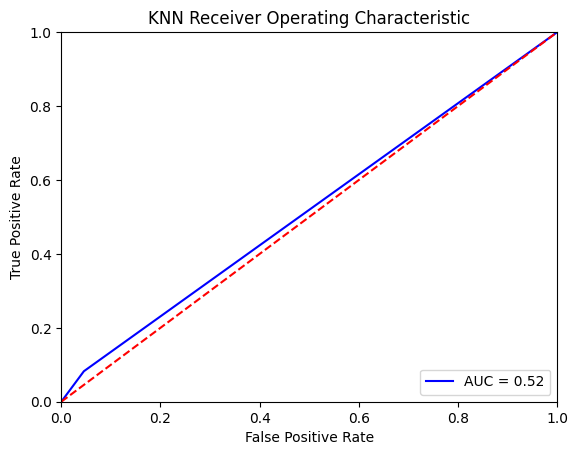

SVM
0.6436781609195402
Cross Validation value is  0.6706896551724137
[[951 498]
 [122 169]]
              precision    recall  f1-score   support

         0.0       0.89      0.66      0.75      1449
         1.0       0.25      0.58      0.35       291

    accuracy                           0.64      1740
   macro avg       0.57      0.62      0.55      1740
weighted avg       0.78      0.64      0.69      1740

0.6185353567693326


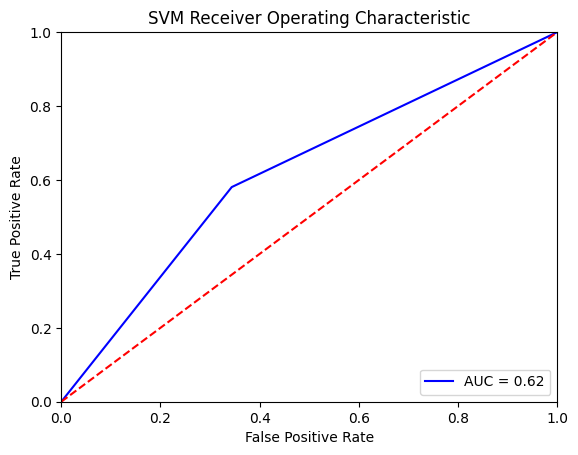

LGBM
0.6718390804597701
Cross Validation value is  0.735632183908046
[[1023  426]
 [ 145  146]]
              precision    recall  f1-score   support

         0.0       0.88      0.71      0.78      1449
         1.0       0.26      0.50      0.34       291

    accuracy                           0.67      1740
   macro avg       0.57      0.60      0.56      1740
weighted avg       0.77      0.67      0.71      1740

0.6038611769225843


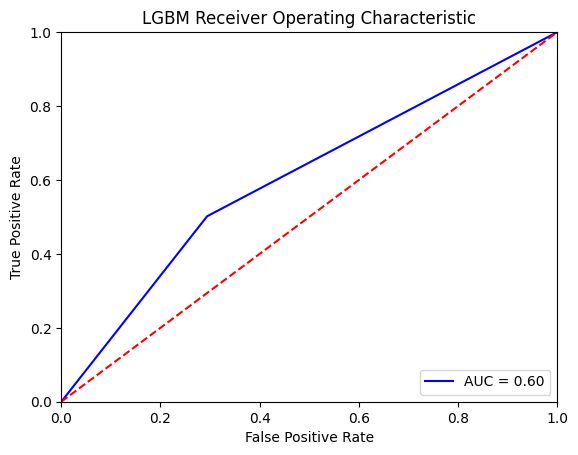

MinMax Scaler
Random Forest
0.828735632183908
Cross Validation value is  0.8327586206896551
[[1441    8]
 [ 290    1]]
              precision    recall  f1-score   support

         0.0       0.83      0.99      0.91      1449
         1.0       0.11      0.00      0.01       291

    accuracy                           0.83      1740
   macro avg       0.47      0.50      0.46      1740
weighted avg       0.71      0.83      0.76      1740

0.4989576885587643


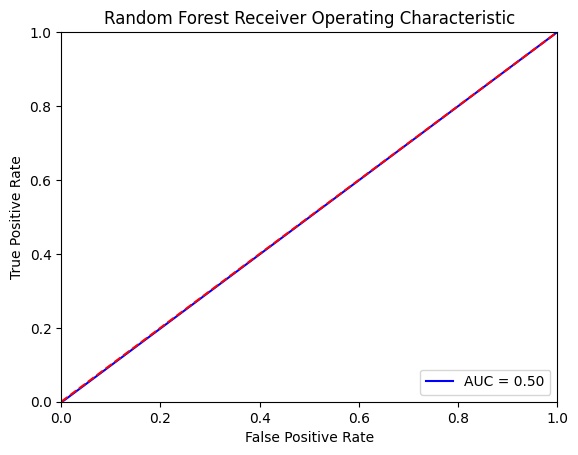

KNN
0.8103448275862069
Cross Validation value is  0.8137931034482758
[[1384   65]
 [ 265   26]]
              precision    recall  f1-score   support

         0.0       0.84      0.96      0.89      1449
         1.0       0.29      0.09      0.14       291

    accuracy                           0.81      1740
   macro avg       0.56      0.52      0.51      1740
weighted avg       0.75      0.81      0.77      1740

0.522244277959204


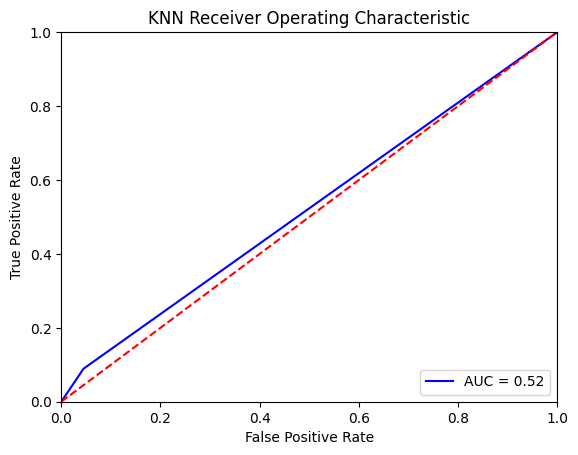

SVM
0.6028735632183908
Cross Validation value is  0.6264367816091954
[[867 582]
 [109 182]]
              precision    recall  f1-score   support

         0.0       0.89      0.60      0.72      1449
         1.0       0.24      0.63      0.35       291

    accuracy                           0.60      1740
   macro avg       0.56      0.61      0.53      1740
weighted avg       0.78      0.60      0.65      1740

0.611886619282406


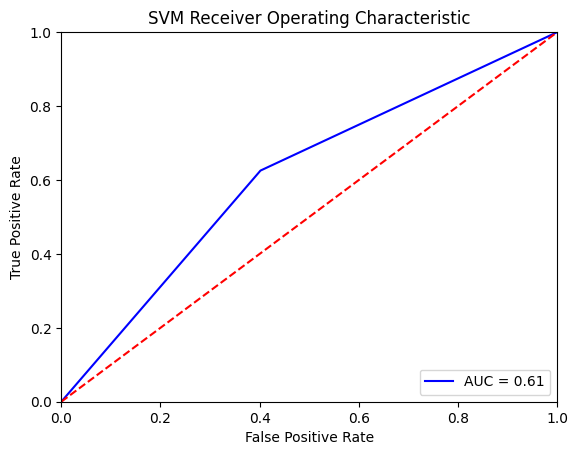

LGBM
0.6706896551724137
Cross Validation value is  0.743103448275862
[[1019  430]
 [ 143  148]]
              precision    recall  f1-score   support

         0.0       0.88      0.70      0.78      1449
         1.0       0.26      0.51      0.34       291

    accuracy                           0.67      1740
   macro avg       0.57      0.61      0.56      1740
weighted avg       0.77      0.67      0.71      1740

0.6059173407895952


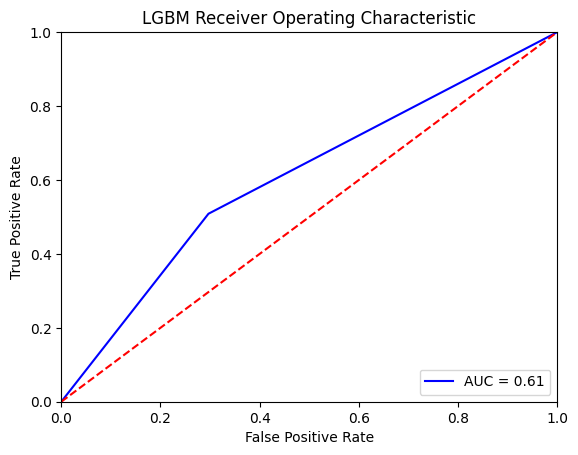

([0.8293103448275863,
  0.8086206896551724,
  0.6436781609195402,
  0.6718390804597701,
  0.828735632183908,
  0.8103448275862069,
  0.6028735632183908,
  0.6706896551724137],
 [0.8304597701149424,
  0.8126436781609195,
  0.6706896551724137,
  0.735632183908046,
  0.8304597701149424,
  0.8137931034482758,
  0.6264367816091954,
  0.743103448275862],
 [0.502049049113146,
  0.5184627862799086,
  0.6185353567693326,
  0.6038611769225843,
  0.4989576885587643,
  0.522244277959204,
  0.611886619282406,
  0.6059173407895952],
 ['              precision    recall  f1-score   support\n\n         0.0       0.83      0.99      0.91      1449\n         1.0       0.25      0.01      0.02       291\n\n    accuracy                           0.83      1740\n   macro avg       0.54      0.50      0.46      1740\nweighted avg       0.74      0.83      0.76      1740\n',
  '              precision    recall  f1-score   support\n\n         0.0       0.84      0.95      0.89      1449\n         1.0       0

In [6]:
from sklearn.ensemble import IsolationForest

# Isolation Forest

scaler = MinMaxScaler()
df_normalize = scaler.fit_transform(df)
# Convert the scaled data back to a DataFrame
df_normalize = pd.DataFrame(df_normalize, columns=df.columns)

iso_forest = IsolationForest(contamination=0.13, random_state=42)
outliers_iso = iso_forest.fit_predict(df_normalize)

# print(f"Outliers detected: {(outliers_iso == -1).sum()} / {len(outliers_iso)}")

# Mark outliers (1 = inlier, -1 = outlier)
outliers_iso = (outliers_iso == -1)

# Filter out outliers 
df_no_outliers_iso = df_normalize[~outliers_iso]  # keep only the inliers

# Perform classification on the data without outliers
perform_classification_weighted(df_no_outliers_iso)



Standard Scaler
Random Forest
0.8304597701149425
Cross Validation value is  0.8298850574712645
[[1441    8]
 [ 287    4]]
              precision    recall  f1-score   support

         0.0       0.83      0.99      0.91      1449
         1.0       0.33      0.01      0.03       291

    accuracy                           0.83      1740
   macro avg       0.58      0.50      0.47      1740
weighted avg       0.75      0.83      0.76      1740

0.504112327734022


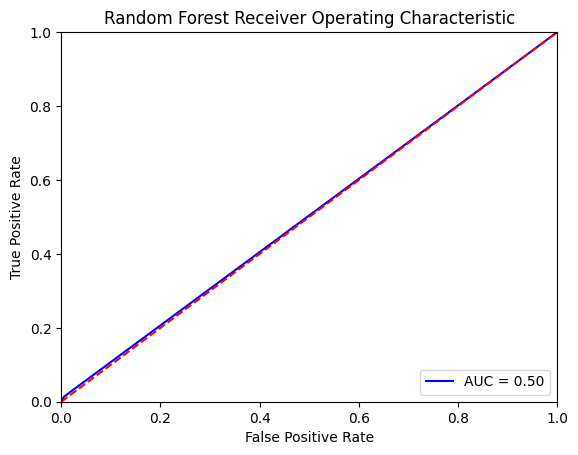

KNN
0.8086206896551724
Cross Validation value is  0.8126436781609195
[[1383   66]
 [ 267   24]]
              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89      1449
         1.0       0.27      0.08      0.13       291

    accuracy                           0.81      1740
   macro avg       0.55      0.52      0.51      1740
weighted avg       0.74      0.81      0.76      1740

0.5184627862799086


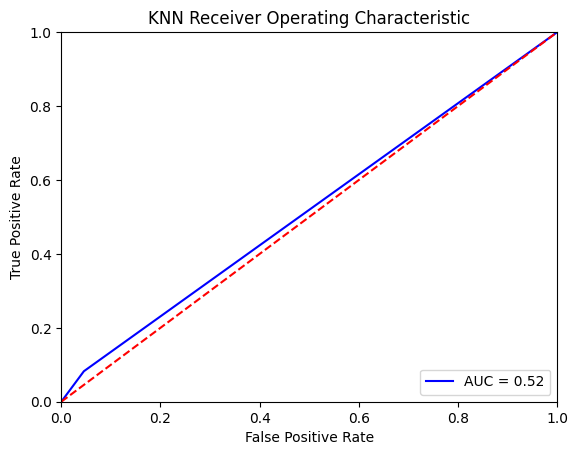

SVM
0.6436781609195402
Cross Validation value is  0.6706896551724137
[[951 498]
 [122 169]]
              precision    recall  f1-score   support

         0.0       0.89      0.66      0.75      1449
         1.0       0.25      0.58      0.35       291

    accuracy                           0.64      1740
   macro avg       0.57      0.62      0.55      1740
weighted avg       0.78      0.64      0.69      1740

0.6185353567693326


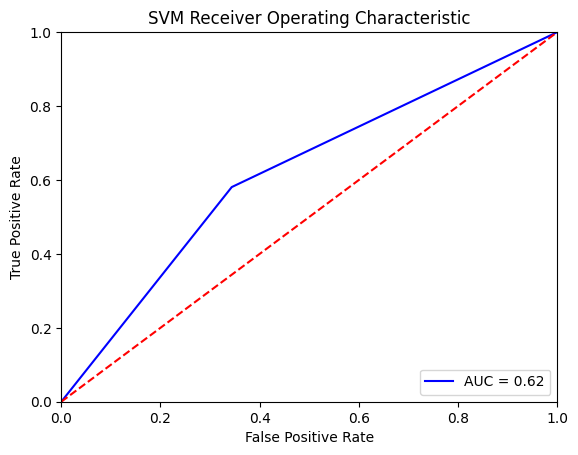

LGBM
0.6718390804597701
Cross Validation value is  0.735632183908046
[[1023  426]
 [ 145  146]]
              precision    recall  f1-score   support

         0.0       0.88      0.71      0.78      1449
         1.0       0.26      0.50      0.34       291

    accuracy                           0.67      1740
   macro avg       0.57      0.60      0.56      1740
weighted avg       0.77      0.67      0.71      1740

0.6038611769225843


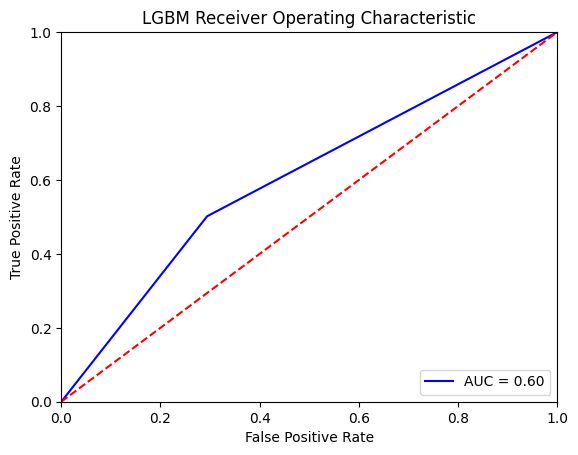

MinMax Scaler
Random Forest
0.8304597701149425
Cross Validation value is  0.8316091954022988
[[1441    8]
 [ 287    4]]
              precision    recall  f1-score   support

         0.0       0.83      0.99      0.91      1449
         1.0       0.33      0.01      0.03       291

    accuracy                           0.83      1740
   macro avg       0.58      0.50      0.47      1740
weighted avg       0.75      0.83      0.76      1740

0.504112327734022


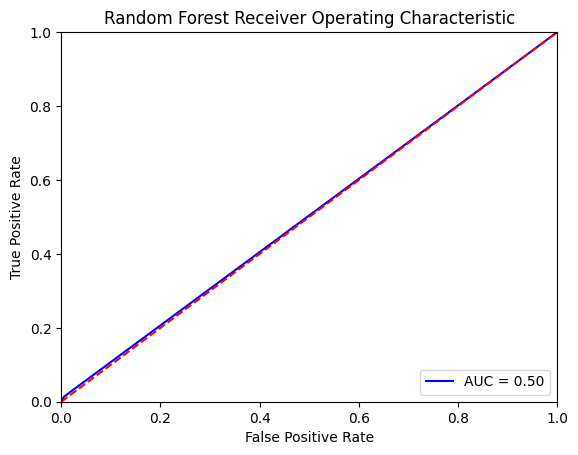

KNN
0.8103448275862069
Cross Validation value is  0.8137931034482758
[[1384   65]
 [ 265   26]]
              precision    recall  f1-score   support

         0.0       0.84      0.96      0.89      1449
         1.0       0.29      0.09      0.14       291

    accuracy                           0.81      1740
   macro avg       0.56      0.52      0.51      1740
weighted avg       0.75      0.81      0.77      1740

0.522244277959204


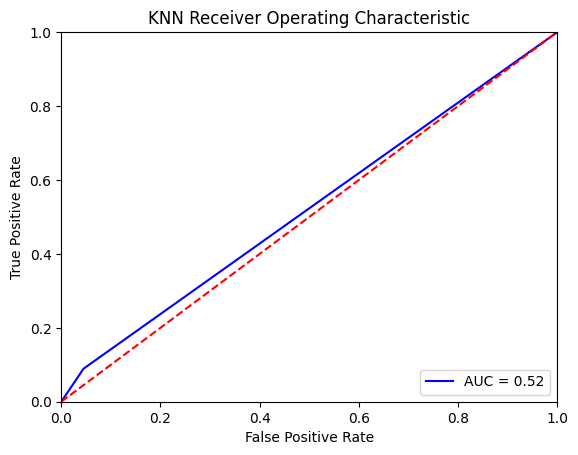

SVM
0.6028735632183908
Cross Validation value is  0.6264367816091954
[[867 582]
 [109 182]]
              precision    recall  f1-score   support

         0.0       0.89      0.60      0.72      1449
         1.0       0.24      0.63      0.35       291

    accuracy                           0.60      1740
   macro avg       0.56      0.61      0.53      1740
weighted avg       0.78      0.60      0.65      1740

0.611886619282406


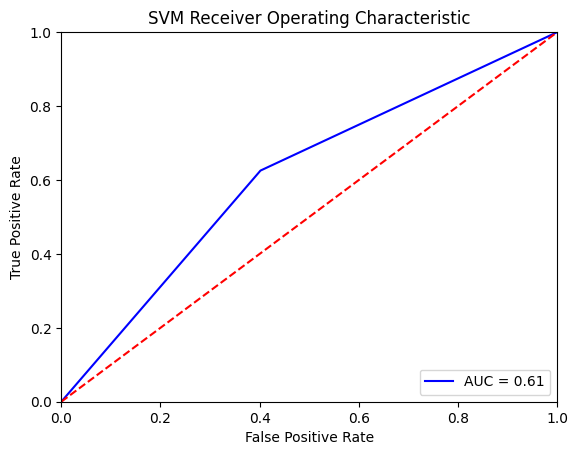

LGBM
0.6706896551724137
Cross Validation value is  0.743103448275862
[[1019  430]
 [ 143  148]]
              precision    recall  f1-score   support

         0.0       0.88      0.70      0.78      1449
         1.0       0.26      0.51      0.34       291

    accuracy                           0.67      1740
   macro avg       0.57      0.61      0.56      1740
weighted avg       0.77      0.67      0.71      1740

0.6059173407895952


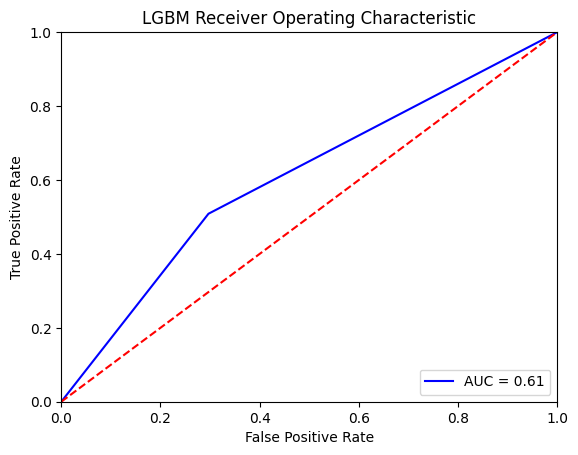

([0.8304597701149425,
  0.8086206896551724,
  0.6436781609195402,
  0.6718390804597701,
  0.8304597701149425,
  0.8103448275862069,
  0.6028735632183908,
  0.6706896551724137],
 [0.8327586206896551,
  0.8126436781609195,
  0.6706896551724137,
  0.735632183908046,
  0.8316091954022988,
  0.8137931034482758,
  0.6264367816091954,
  0.743103448275862],
 [0.504112327734022,
  0.5184627862799086,
  0.6185353567693326,
  0.6038611769225843,
  0.504112327734022,
  0.522244277959204,
  0.611886619282406,
  0.6059173407895952],
 ['              precision    recall  f1-score   support\n\n         0.0       0.83      0.99      0.91      1449\n         1.0       0.33      0.01      0.03       291\n\n    accuracy                           0.83      1740\n   macro avg       0.58      0.50      0.47      1740\nweighted avg       0.75      0.83      0.76      1740\n',
  '              precision    recall  f1-score   support\n\n         0.0       0.84      0.95      0.89      1449\n         1.0       0

In [7]:
# Perform Outlier Detection and Removal
from sklearn.neighbors import LocalOutlierFactor
def perform_outlier_detection(df):
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.13)
    minmax_scalar = MinMaxScaler()
    df_normalize = minmax_scalar.fit_transform(df)

    # Convert the scaled data back to a DataFrame
    df_normalize = pd.DataFrame(df_normalize, columns=df.columns)
        
    outliers_lof = lof.fit_predict(df)

    outliers_lof = (outliers_lof == -1)
    df_no_outliers_lof = df_normalize[~outliers_iso]

    return df_no_outliers_lof

df_no_outliers_lof = perform_outlier_detection(df)

# Perform classification on the data without outliers
perform_classification_weighted(df_no_outliers_lof)

